<a href="https://colab.research.google.com/github/vimassaru/WIA/blob/main/smiledataai_segformer_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install torch timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.5 MB/s eta 0:00:00


In [5]:
# Em caso de accelerate der erro, devemos realizar o pip install e reiniciar
# o notebook

!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 6.9 MB/s eta 0:00:00


Acessando a base de dados no drive

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Pré Processamento dos dados

Corrigindo o dataframe

Criando Mapeamento das Classes

Criando o one-hot-encode para as máscaras do dataset

Criando o Fine-Tuning para o dataset de imagens de raio-x

In [7]:
!pip install -q transformers datasets evaluate segments-ai;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 5.0 MB/s eta 0:00:00


In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
# Visualizando as classes
import pandas as pd
import csv
import json

def read_csv_file(csv_path):
  class_info = pd.read_csv(csv_path)
  return class_info

csv_path_file = '/content/drive/MyDrive/2023/semantic_segmentation_project/datasets/teeth_dataset/_classes.csv'

class_df = read_csv_file(csv_path_file)

# Removendo os espaços em brancos no dataframe
class_df.columns = class_df.columns.str.strip()

# # Modificando o valor background
# class_df.loc[0, 'Class'] = -1

# Definindo o dict para as classes
class_mapping = {}

# Definindo a lista para os labels
class_labels = []
class_df


,Pixel Value,Class
0,0,background
1,1,11
2,2,12
3,3,13
4,4,14
5,5,15
6,6,16
7,7,17
8,8,18
9,9,21


In [6]:
# Convertendo arquivo CSV para JSON
data = class_df.to_dict(orient='records')

# Caminho para salvar o arquivo JSON
json_path = '/content/drive/MyDrive/2023/semantic_segmentation_project/datasets/teeth_dataset/teeth_label.json'

# Removendo os espaços desnecessários nas classes
for item in data:
    item['Class'] = item['Class'].strip()

# Salvando o dicionário em formato JSON

with open(json_path, 'w') as json_file:
    json.dump(data, json_file)

print(json_path)

/content/drive/MyDrive/2023/semantic_segmentation_project/datasets/teeth_dataset/teeth_label.json


# Configurações

Definindo as variaveis bases para o ambiente

In [23]:
import gc
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path

from timm import create_model
from timm.models import HighResolutionNet

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as NNF
from torch.utils.data import DataLoader
from torchvision.datasets import VisionDataset
from torchvision import transforms
from torchvision.transforms import functional as F
from torchvision.transforms.functional import to_tensor

TRAIN_FOLDER = '/content/drive/MyDrive/2023/semantic_segmentation_project/datasets/teeth_dataset/train'
TEST_FOLDER = '/content/drive/MyDrive/2023/semantic_segmentation_project/datasets/teeth_dataset/test'

# Dataset

Definindo um dataset customizado para utilizar no Pytorch

In [7]:
from pathlib import Path

def create_image_mask_lists(data_folder):
    data_folder = Path(data_folder)
    image_list = []
    mask_list = []

    image_folder = data_folder / "image"
    mask_folder = data_folder / "label"

    # Verificar se as pastas de imagem e máscara existem
    if not image_folder.exists() or not mask_folder.exists():
        raise ValueError(f"Pastas 'image' e 'label' não foram encontradas" +
                         f" em {data_folder}.")

    # Listar os arquivos de imagem na pasta 'image'
    image_files = list(image_folder.glob('*.[jp]*g')) + list(image_folder.glob('*.png'))  # Filtrar extensões válidas

    # Verificar se há arquivos de imagem correspondentes
    if not image_files:
        raise ValueError('Nenhum arquivo de imagem válido' +
                         f" encontrado em {image_folder}.")

    # Listar os arquivos de máscara na pasta 'label'
    mask_files = list(mask_folder.glob('*.png'))  # Filtrar extensões válidas

    # Verificar se há arquivos de máscara correspondentes
    if not mask_files:
        raise ValueError('Nenhum arquivo de máscara válido' +
                         f" encontrado em {mask_folder}.")

    # Ordenar os arquivos para garantir que correspondam
    image_files.sort()
    mask_files.sort()

    # Verificar se o número de arquivos de imagem e máscara é o mesmo
    if len(image_files) != len(mask_files):
        base_1 = f"O número de arquivos de imagem ({len(image_files)}) "
        base_2 = 'é diferente do número '
        base_3 = f"de arquivos de máscara ({len(mask_files)})."
        base_4 = 'Certifique-se de que cada imagem '
        base_4 = 'tem uma máscara correspondente.'
        raise ValueError(base_1 + base_2 + base_3 + base_4 + base_5)

    # Criar a lista de caminhos completos para as imagens e máscaras
    for image_file, mask_file in zip(image_files, mask_files):
        image_list.append(str(image_file))
        mask_list.append(str(mask_file))

    return image_list, mask_list


In [8]:
from datasets import Dataset, DatasetDict, Image

def create_dataset(image_paths, mask_paths):
    dataset = Dataset.from_dict({"image": sorted(image_paths),
                                "label": sorted(mask_paths)})
    dataset = dataset.cast_column("image", Image())
    dataset = dataset.cast_column("label", Image())

    return dataset

In [10]:
# criando as listas de treino:
train_folder = Path(TRAIN_FOLDER)
image_list, mask_list = create_image_mask_lists(train_folder)

print(image_list, mask_list)

['/content/drive/MyDrive/2023/semantic_segmentation_project/datasets/teeth_dataset/train/image/100_png23a801b2d65aa55e991be54db935ebe2.jpg', '/content/drive/MyDrive/2023/semantic_segmentation_project/datasets/teeth_dataset/train/image/101_png72bafe6ac521ae2e48d95dcc29f5177d.jpg', '/content/drive/MyDrive/2023/semantic_segmentation_project/datasets/teeth_dataset/train/image/102_png67b69a157fa5f9398a2e501020fc15f9.jpg', '/content/drive/MyDrive/2023/semantic_segmentation_project/datasets/teeth_dataset/train/image/103_pngb0713a88223320c98a82523aad821254.jpg', '/content/drive/MyDrive/2023/semantic_segmentation_project/datasets/teeth_dataset/train/image/104_png14b8e081cfe59bbda58ffd4493fa9334.jpg', '/content/drive/MyDrive/2023/semantic_segmentation_project/datasets/teeth_dataset/train/image/105_png58611b211188fcf35ab9ce51c6153b5c.jpg', '/content/drive/MyDrive/2023/semantic_segmentation_project/datasets/teeth_dataset/train/image/106_pngceeac55b3d62295947f4ee53bc13fb25.jpg', '/content/drive/MyD

In [11]:
# Criando os datasets de treino e teste
train_dataset = create_dataset(image_list, mask_list)

train_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 80
})

In [12]:
# criando as listas de treino:
test_folder = Path(TEST_FOLDER)
image_list, mask_list = create_image_mask_lists(test_folder)

print(image_list, mask_list)

# Criando dataset de teste
test_dataset = create_dataset(image_list, mask_list)

print(test_dataset)

['/content/drive/MyDrive/2023/semantic_segmentation_project/datasets/teeth_dataset/test/image/109_png058f5b68cbd9251f2d54e71de6c0f7b7.jpg', '/content/drive/MyDrive/2023/semantic_segmentation_project/datasets/teeth_dataset/test/image/10_png74838a92fc1d2d6697da121438aa4ece.jpg', '/content/drive/MyDrive/2023/semantic_segmentation_project/datasets/teeth_dataset/test/image/110_png218ead78abc05df67cd7a8e4ac324457.jpg', '/content/drive/MyDrive/2023/semantic_segmentation_project/datasets/teeth_dataset/test/image/113_pngce3d7a4e83c0eddae405a8c847cf3acc.jpg', '/content/drive/MyDrive/2023/semantic_segmentation_project/datasets/teeth_dataset/test/image/116_pngd7e215d0f94995bdb730933f7f22cc66.jpg', '/content/drive/MyDrive/2023/semantic_segmentation_project/datasets/teeth_dataset/test/image/13_pngbd944d582477a0607e19b19a4287f3d2.jpg', '/content/drive/MyDrive/2023/semantic_segmentation_project/datasets/teeth_dataset/test/image/16_pngb8b5b6d65e40a831538546339f41177f.jpg', '/content/drive/MyDrive/2023/

Criar um dicionario DatasetDict

In [13]:
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset,
  }
)

user_hf_dataset = "username/dataset_id"

# dataset.push_to_hub(f"{user_hf_dataset}")

In [14]:
from datasets import load_dataset

hf_identifier = 'vimassaru/teethsegmentation'

hf_dataset = load_dataset(hf_identifier)

hf_dataset

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 80
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 33
    })
})

In [15]:
train_ds = hf_dataset["train"]
test_ds = hf_dataset["test"]

In [16]:
from huggingface_hub import hf_hub_download

filename = "data/teeth_label.json"
data_list = json.load(open(hf_hub_download(repo_id=hf_identifier, filename=filename, repo_type="dataset"), "r"))

id2label = {}
for data in data_list:
    id_ = int(data['Pixel Value'])
    label = data['Class'].strip()  # Remova espaços desnecessários no início e no final da classe
    id2label[id_] = label

label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)
print("Id2label:", id2label)

Id2label: {0: 'background', 1: '11', 2: '12', 3: '13', 4: '14', 5: '15', 6: '16', 7: '17', 8: '18', 9: '21', 10: '22', 11: '23', 12: '24', 13: '25', 14: '26', 15: '27', 16: '28', 17: '31', 18: '32', 19: '33', 20: '34', 21: '35', 22: '36', 23: '37', 24: '38', 25: '41', 26: '42', 27: '43', 28: '44', 29: '45', 30: '46', 31: '47', 32: '48'}


# Fine Tuning do Modelo

In [22]:
from transformers import SegformerForSemanticSegmentation

pretrained_model_name = "nvidia/mit-b0"
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_fuse.weight', 'decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode

Transformações necessárias para o treino do modelo SegFormer

In [39]:
from torch.utils.checkpoint import checkpoint
from torchvision.transforms import ColorJitter
from transformers import (
    SegformerFeatureExtractor,
)

feature_extractor = SegformerFeatureExtractor()
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch['image']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch['image']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


Treino do modelo utilizando o a lib `transformers`

In [30]:

from transformers import TrainingArguments

epochs = 200
lr = 0.0006
batch_size = 8

hub_model_id = "segformer-b0-finetuned-segments-sidewalk-oct-22"

training_args = TrainingArguments(
    "segformer-b0-finetuned-segments-sidewalk-outputs",
    remove_unused_columns=False,
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id=hub_model_id,
    hub_strategy="end",
)

Validar os dados pelo índice de jaccard:

$
\begin{align}
    \text{IoU} = \frac{\text{Área de Sobreposição}}{\text{Área de União}}
\end{align}
$

In [31]:
import torch
from torch import nn
import evaluate
import multiprocessing

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=True,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=feature_extractor.do_reduce_labels,
        )

    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    return metrics

In [32]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/vimassaru/segformer-b0-finetuned-segments-sidewalk-oct-22 into local empty directory.


Download file pytorch_model.bin:   0%|          | 17.4k/14.3M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.93k/3.93k [00:00<?, ?B/s]

Clean file training_args.bin:  25%|##5       | 1.00k/3.93k [00:00<?, ?B/s]

Download file runs/Jul05_02-17-25_b07670459616/events.out.tfevents.1688523472.b07670459616.4491.0:   2%|2     …

Clean file runs/Jul05_02-17-25_b07670459616/events.out.tfevents.1688523472.b07670459616.4491.0:   0%|         …

Clean file pytorch_model.bin:   0%|          | 1.00k/14.3M [00:00<?, ?B/s]

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Background,Accuracy 11,Accuracy 12,Accuracy 13,Accuracy 14,Accuracy 15,Accuracy 16,Accuracy 17,Accuracy 18,Accuracy 21,Accuracy 22,Accuracy 23,Accuracy 24,Accuracy 25,Accuracy 26,Accuracy 27,Accuracy 28,Accuracy 31,Accuracy 32,Accuracy 33,Accuracy 34,Accuracy 35,Accuracy 36,Accuracy 37,Accuracy 38,Accuracy 41,Accuracy 42,Accuracy 43,Accuracy 44,Accuracy 45,Accuracy 46,Accuracy 47,Accuracy 48,Iou Background,Iou 11,Iou 12,Iou 13,Iou 14,Iou 15,Iou 16,Iou 17,Iou 18,Iou 21,Iou 22,Iou 23,Iou 24,Iou 25,Iou 26,Iou 27,Iou 28,Iou 31,Iou 32,Iou 33,Iou 34,Iou 35,Iou 36,Iou 37,Iou 38,Iou 41,Iou 42,Iou 43,Iou 44,Iou 45,Iou 46,Iou 47,Iou 48
20,1.161100,2.116303,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
40,0.992600,1.430934,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60,0.975500,0.987190,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
80,0.767800,1.029678,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
100,0.905300,0.864951,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
120,0.817900,0.882163,0.000000,0.000000,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.00000

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: inval

In [33]:
print(hub_model_id)

segformer-b0-finetuned-segments-sidewalk-oct-22


In [26]:
hf_identifier_dataset = 'vimassaru/teethsegmentation'

In [27]:
kwargs = {
    "tags": ["vision", "image-segmentation", "odontology", "x-ray"],
    "finetuned_from": pretrained_model_name,
    "dataset": hf_identifier_dataset,
}

feature_extractor.push_to_hub(hf_identifier_dataset, private=True)
trainer.push_to_hub(**kwargs)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 8>:8                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'trainer' is not defined

# Inferência dos Dados



## Notas

É importante rodar de forma separada o treino e do modelo e a validação (Inferência de Dados) para que o modelo não carregue um numpy array no lugar da imagem.

## Carregando os dados

In [41]:
from datasets import load_dataset

hf_identifier = 'vimassaru/teethsegmentation'

hf_dataset = load_dataset(hf_identifier)

hf_dataset

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 80
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 33
    })
})

In [42]:
train_ds = hf_dataset["train"]
test_ds = hf_dataset["test"]

In [43]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

model_trained = 'vimassaru/segformer-b0-finetuned-segments-sidewalk-oct-22'

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained(f'{model_trained}')

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [44]:
test_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 33
})

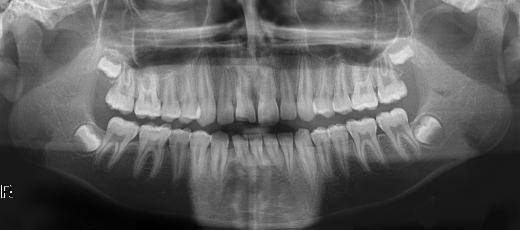

In [45]:
# Carregando imagem do dataset
image = test_ds[0]['image']
gt_seg = test_ds[0]['label']
image

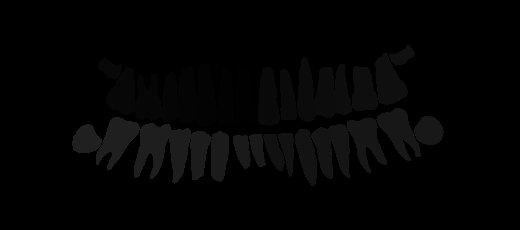

In [46]:
# get_set
gt_seg

Após carregar a imagem precisamos preparar ela utilizando o feature extractor

In [30]:
gt_seg.size

(520, 231)

In [38]:
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1], # (height, width)
    mode='bilinear',
    align_corners=False
)

# Second, apply argmax on the class dimension
pred_seg = upsampled_logits.argmax(dim=1)[0]

In [30]:
# NNF alias para nn.functional

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# First, rescale logits to original image size
original_height, original_width = image.size[-2], image.size[-1]
upsampled_logits = NNF.interpolate(
    logits,
    size=(original_height, original_width), # (height, width)
    mode='bilinear',
    align_corners=False
)

# # Second, apply argmax on the class dimension
pred_seg = upsampled_logits.argmax(dim=1)[0]

Definindo a paleta de cores das classes

In [31]:
class_colors = {
    'background': (0, 0, 0),
    '11': (255, 0, 0),
    '12': (0, 255, 0),
    '13': (0, 0, 255),
    '14': (255, 255, 0),
    '15': (255, 0, 255),
    '16': (0, 255, 255),
    '17': (255, 128, 0),
    '18': (128, 0, 255),
    '21': (0, 255, 128),
    '22': (128, 255, 0),
    '23': (0, 128, 255),
    '24': (255, 0, 128),
    '25': (128, 255, 128),
    '26': (128, 128, 255),
    '27': (255, 128, 128),
    '28': (128, 128, 128),
    '31': (0, 0, 128),
    '32': (0, 128, 0),
    '33': (128, 0, 0),
    '34': (0, 128, 128),
    '35': (128, 0, 128),
    '36': (128, 128, 0),
    '37': (128, 64, 0),
    '38': (64, 128, 0),
    '41': (0, 64, 128),
    '42': (64, 0, 128),
    '43': (128, 128, 64),
    '44': (64, 64, 128),
    '45': (128, 64, 64),
    '46': (64, 128, 64),
    '47': (128, 128, 64),
    '48': (64, 128, 128),
}

class_mapping_colors = list(class_colors.values())

class_mapping_colors

[(0, 0, 0),
 (255, 0, 0),
 (0, 255, 0),
 (0, 0, 255),
 (255, 255, 0),
 (255, 0, 255),
 (0, 255, 255),
 (255, 128, 0),
 (128, 0, 255),
 (0, 255, 128),
 (128, 255, 0),
 (0, 128, 255),
 (255, 0, 128),
 (128, 255, 128),
 (128, 128, 255),
 (255, 128, 128),
 (128, 128, 128),
 (0, 0, 128),
 (0, 128, 0),
 (128, 0, 0),
 (0, 128, 128),
 (128, 0, 128),
 (128, 128, 0),
 (128, 64, 0),
 (64, 128, 0),
 (0, 64, 128),
 (64, 0, 128),
 (128, 128, 64),
 (64, 64, 128),
 (128, 64, 64),
 (64, 128, 64),
 (128, 128, 64),
 (64, 128, 128)]

In [39]:
def get_seg_overlay(image, seg):
  color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
  palette = np.array(class_mapping_colors)
  for label, color in enumerate(palette):
      color_seg[seg == label, :] = color

  # Show image + mask
  img = np.array(image) * 0.5 + color_seg * 0.5
  img = img.astype(np.uint8)

  return img

In [47]:
print(f'pred_size: {pred_seg.size}')
print(f'image_size: {image.size}')

pred_size: <built-in method size of Tensor object at 0x7f94c200c2c0>
image_size: (520, 230)


# Resultados

## Predição e Ground Truth

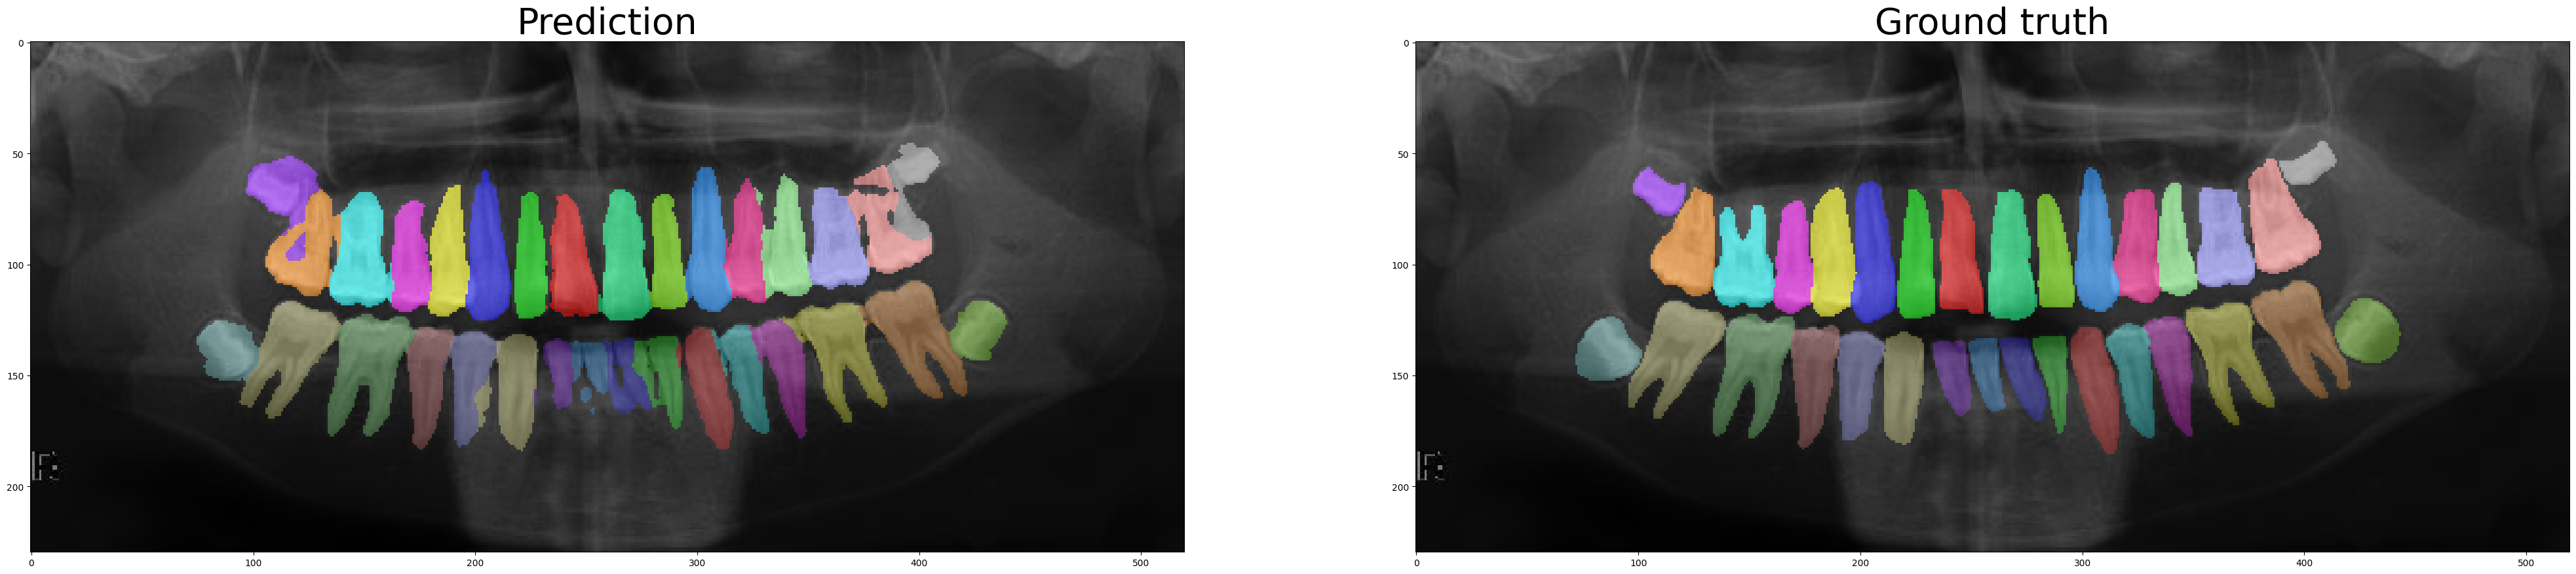

In [48]:
import matplotlib.pyplot as plt

pred_img = get_seg_overlay(image, pred_seg)
gt_img = get_seg_overlay(image, np.array(gt_seg))

f, axs = plt.subplots(1, 2)
f.set_figheight(30)
f.set_figwidth(50)

axs[0].set_title("Prediction", {'fontsize': 40})
axs[0].imshow(pred_img)
axs[1].set_title("Ground truth", {'fontsize': 40})
axs[1].imshow(gt_img);

Média do IoU por classe e época

In [55]:
!pip install plotly

In [88]:
validation_data = pd.read_csv('/content/drive/MyDrive/2023/semantic_segmentation_project/datasets/teeth_dataset/resultados_modelo_semantic_seg.csv')

In [59]:
import pandas as pd
import plotly.graph_objects as go

# Obter os valores das colunas relevantes
epochs = validation_data['Epoch']
mean_iou = validation_data['Mean Iou']

# Criar um gráfico de linhas interativo com Plotly
fig_jaccard_index = go.Figure()

# Adicionar os dados ao gráfico
fig_jaccard_index.add_trace(go.Scatter(x=epochs, y=mean_iou, mode='lines+markers'))

# Configurar os rótulos e título do gráfico
fig_jaccard_index.update_layout(
    xaxis_title='Épocas',
    yaxis_title='Mean IoU',
    title='Média do Index Jaccard por Época',
)

# Exibir o gráfico interativo
fig_jaccard_index.show()

In [61]:
# Obter os valores das colunas relevantes
epochs = validation_data['Epoch']
training_losss = validation_data['Training Loss']

# Criar um gráfico de linhas interativo com Plotly
fig_training_loss = go.Figure()

# Adicionar os dados ao gráfico
fig_training_loss.add_trace(go.Scatter(x=epochs, y=training_losss, mode='lines+markers'))

# Configurar os rótulos e título do gráfico
fig_training_loss.update_layout(
    xaxis_title='Épocas',
    yaxis_title='Training Loss',
    title='Training Loss por Época',
)

# Exibir o gráfico interativo
fig_training_loss.show()

In [75]:
# Obter os valores das colunas relevantes
epochs = validation_data['Epoch']
validation_losss = validation_data['Validation Loss']

# Criar um gráfico de linhas interativo com Plotly
fig_validation_loss = go.Figure()

# Adicionar os dados ao gráfico
fig_validation_loss.add_trace(go.Scatter(x=epochs, y=validation_losss, mode='lines+markers'))

# Configurar os rótulos e título do gráfico
fig_validation_loss.update_layout(
    xaxis_title='Épocas',
    yaxis_title='Validation Loss',
    title='Validation Loss por Época',
)

# Exibir o gráfico interativo
fig_validation_loss.show()